# Deep models interpretability
This notebooks shows examples of approaches for interpretation of (pre-)trained model predictions.

In [1]:
try:
    import skimage
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'scikit-image'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import skimage

In [2]:
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models

import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

device: cpu


In [4]:
# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}

In [5]:
class_labels[897]

'washer'

### Task I: manual explanation with smoothgrad (2 points)

Let us begin by implementing our own little explainer for [DenseNet121](https://arxiv.org/abs/1608.06993) pretrained on ImageNet.

For the sake of simplicity, we're gonna rely on [SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) explainer - a simple average of gradients over noisy inputs.

In [6]:
model = torchvision.models.densenet121(pretrained=True).train(False).to(device)
#model = torchvision.models.resnet50(pretrained=True).train(False).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 67.4MB/s]


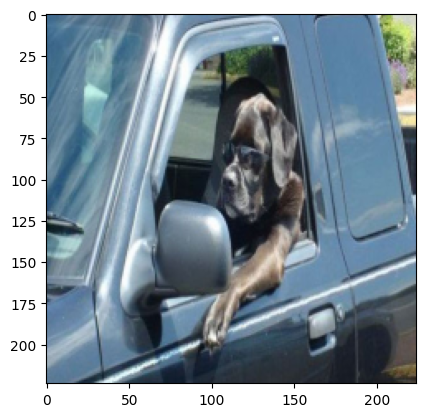

#1: p=0.305	minivan (656)
#2: p=0.195	minibus (654)
#3: p=0.098	seat_belt (785)
#4: p=0.071	limousine (627)
#5: p=0.068	jeep (609)
#6: p=0.046	recreational_vehicle (757)
#7: p=0.037	ambulance (407)
#8: p=0.032	police_van (734)
#9: p=0.024	beach_wagon (436)
#10: p=0.015	bloodhound (163)


In [7]:
!wget -q https://cdn2.adrianflux.co.uk/wp-fluxposure/uploads/2014/08/no-7.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

Now let's implement SmoothGrad itself.

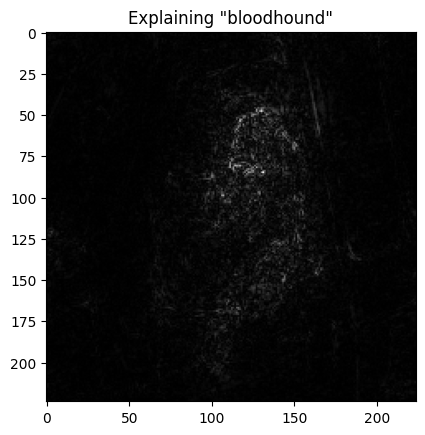

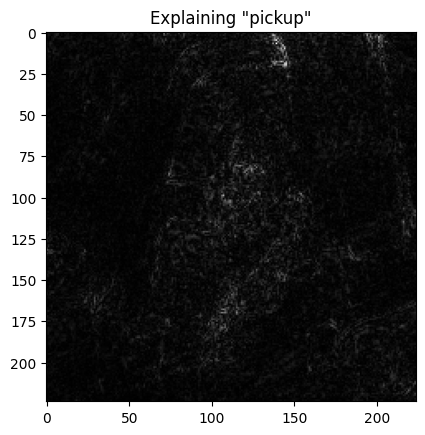

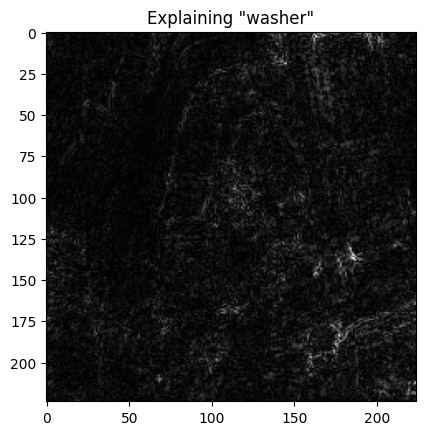

In [8]:
def explain_smoothgrad(image: torch.Tensor, class_ix, num_runs=32, sigma=0.1):
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)  # shape: [1, 3, h, w]

    # 1. create :num_runs: copies of an image
    # 2. apply independent random noise to each copy, use N(0, sigma) distribution
    # 3. compute gradients of logit for class_ix w.r.t. input pixels
    # 4. average these gradients across different images
    # 5. re-shape these gradients in the same shape as original image: (h, w, 3)

    # Copies of images
    image_copies = image_tensor.repeat(num_runs, 1, 1, 1)
    # Apply noise
    noisy_images = image_copies + torch.randn_like(image_copies) * sigma

    gradients = []
    for i in range(num_runs):
        # Compute grad of logit
        noisy_image = noisy_images[i][None]
        noisy_image.requires_grad = True
        logits = model(noisy_image)
        model.zero_grad()
        logits[:, class_ix].backward()
        gradients.append(noisy_image.grad.data)

    # Average the grad
    average_gradients = torch.mean(torch.stack(gradients), dim=0)
    # Re shape
    average_gradients = average_gradients.permute(0, 2, 3, 1).squeeze(0)

    # Average channels for better visualization
    average_gradients = average_gradients.mean(dim=-1) # comment it and uncomment next assert instead.

    #assert tuple(average_gradients.shape) == image.shape

    return abs(average_gradients).cpu().numpy()

for class_ix in 163, 717, 897:  # <-- insert your classes here, use numbers in (brackets)
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

__Let's try it out!__ Peter Higgs nobel prize photo

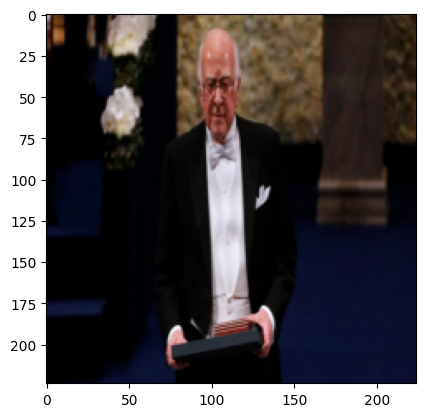

#1: p=0.879	suit (834)
#2: p=0.014	Windsor_tie (906)
#3: p=0.009	lab_coat (617)
#4: p=0.007	bow_tie (457)
#5: p=0.007	groom (982)
#6: p=0.006	toilet_seat (861)
#7: p=0.004	Loafer (630)
#8: p=0.004	academic_gown (400)
#9: p=0.004	grand_piano (579)
#10: p=0.003	toilet_tissue (999)


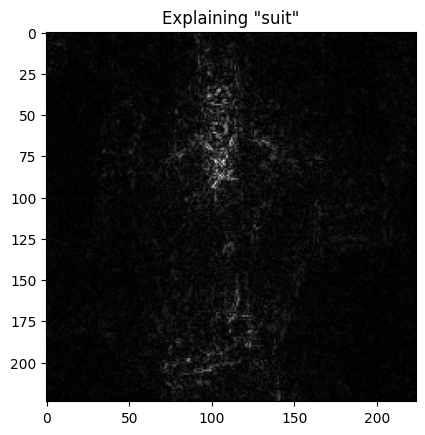

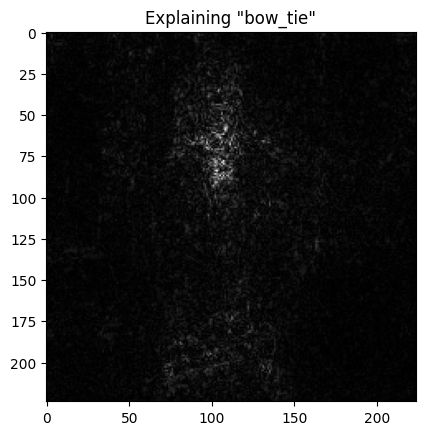

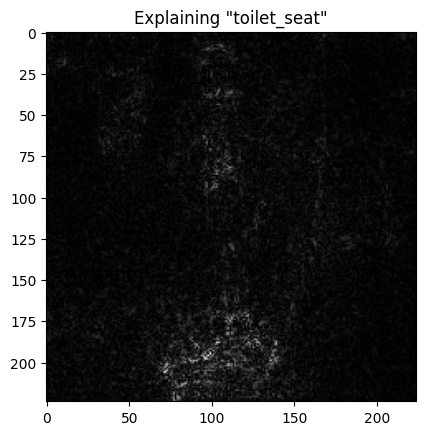

In [9]:
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

for class_ix in 834, 457, 861:
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

### SHapley Additive exPlanations
Now, let's try something heavier. The current state of the art in explaining model predictions is [SHAP](https://arxiv.org/abs/1705.07874): Shapley Additive Explanations.

This method is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) - a game-theoretic concept that evaluates the contribution of individual players in a cooperative game. Except this time our "players" are input features and the "game" is predicting whichever output the model gave.

Computing Shapley values naively requires $O(F!)$ time where F is the number of features. To make this computation more feasible, authors [proposed](https://arxiv.org/abs/1705.07874) several approximations, one of which relies on averaged gradients. This approximation also requires "background" data - other images similar to the ones in question that can be used as reference points.

In [ ]:
try:
    import shap
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'shap'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import shap

In [ ]:
shap.initjs()

# load "background" images - some 50 random images from ImageNet
background, _ = shap.datasets.imagenet50()
background = torch.as_tensor(background / 255.0, device=device, dtype=torch.float32)
background = background.permute(0, 3, 1, 2)

In [ ]:
background.size()

torch.Size([50, 3, 224, 224])

In [ ]:
# image to explain
!wget -q https://i.pinimg.com/originals/32/da/5c/32da5c3314fcc5ebf1a7b7d1548fcb03.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)

In [ ]:
model = torchvision.models.resnet50(pretrained=True).train(False).to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


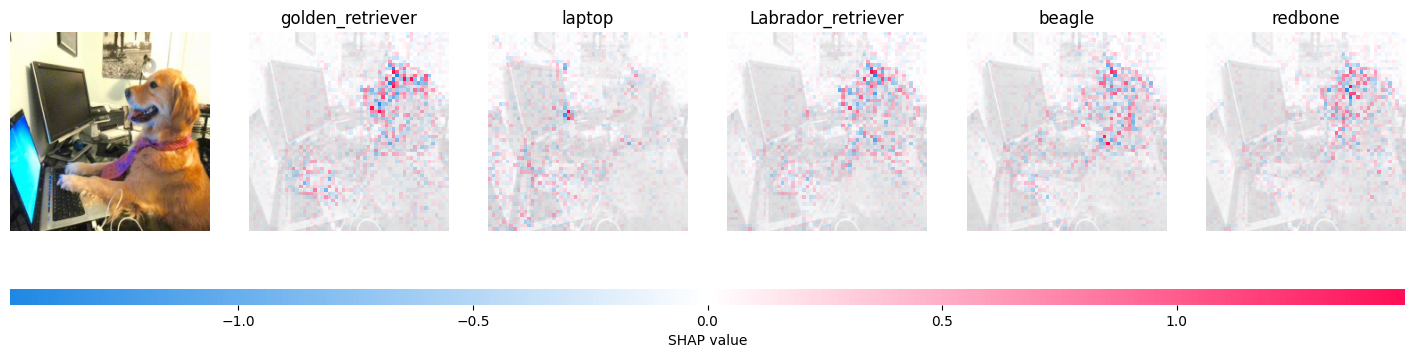

In [ ]:
# explain and visualize. If you're not using a powerful V100 GPU, this may take up to 20 minutes.
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

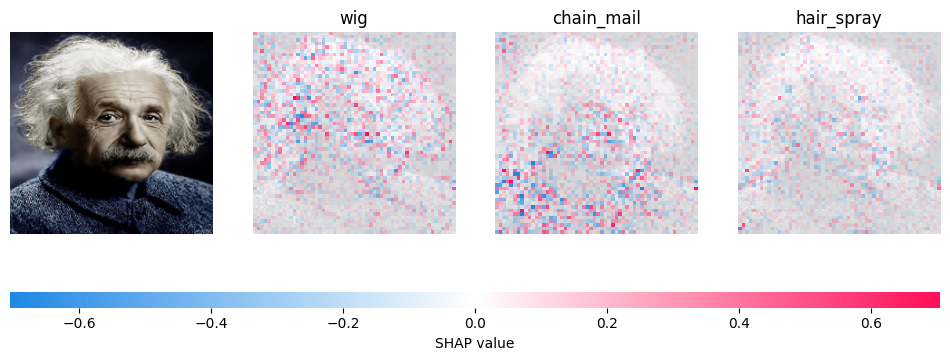

In [ ]:
# obligatory physicist reference
!wget -q https://images-na.ssl-images-amazon.com/images/I/51ArQaCkkZL._AC_.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=3, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

###### Explaining classical machine learning models

Finally, let's see how SHAP explainers can be applied to more conventional machine learning models like gradient boosting.

Spoiler: exactly the same from a user's perspective. However, this time we're gonna use a different Shapley approximation implemented in TreeExplainer. For a full set of available explainers, take a look at their official [examples page](https://github.com/slundberg/shap/tree/master/notebooks).

**NB: the following cells requires JavaScript support and should work in Jupyter (not JupyterLab or cocalc)**.
In that case try running it on Google colab: https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


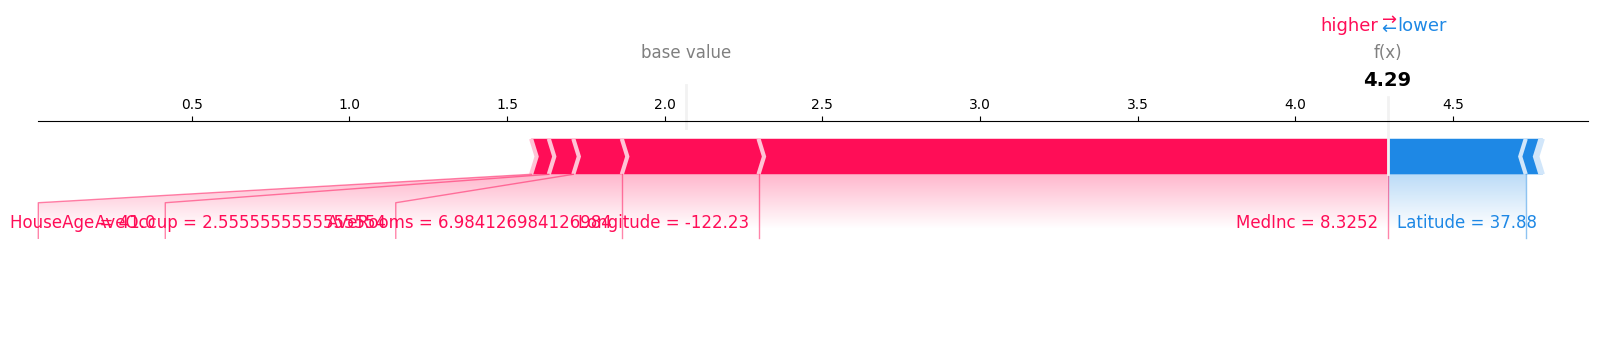

In [ ]:
import catboost # pip install catboost

X, y = shap.datasets.california() # No more boston dataset, instead we have california
ensemble = catboost.CatBoostRegressor(iterations=100, learning_rate=0.1)
ensemble.fit(X, y, verbose=False, plot=False)
explainer = shap.TreeExplainer(ensemble)
shap_values = explainer.shap_values(X)

# visualize explanation of the first example
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :],matplotlib=True)

In [ ]:
# Explain training data: each *column* is a rotated plot from above, stacked for all training samples
# (this plot is interactive, hover mouse to see feature names)
shap.force_plot(explainer.expected_value, shap_values, X)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


### Task II: Explain Intermediate Layers of Resnet50 on ImageNet (5 points)

Sometimes, computing explanations w.r.t. pixels is more difficult (and less interpretable) than using intermediate layers that are closer to the "output" layer. The trick is to compute low-resolution explanations of output w.r.t. intermediate layer and then resizing them to fit the original image.

Each layer in deep CNN learns filters of increasing complexity. The first layers learn basic feature detection filters such as edges and corners. The middle layers learn filters that detect parts of objects — for faces, they might learn to respond to features like eyes and brows, and deeper layers capture entire objects.

**Your task** is to explain ResNet50 model outputs with respect to the convolution module from 2nd  and 4th layer of the pretrained Resnet50 network using the same GradientExplainer. *The task may require some googling or browsing the [docs](https://shap.readthedocs.io/en/latest) :)*

**Please use at least 10 images from across the internet (or from ImageNet) and compare the 2nd and 4th layer explanations on these images.**


In [ ]:
import json

model = models.resnet50(pretrained=True).to(device).eval()

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [ ]:
X, y = shap.datasets.imagenet50()
X /= 255
to_explain = X[[3,5,7,9,11,13,17,19,23,29]]

normalized_X = normalize(X).to(device)
normalized_to_explain = normalize(to_explain).to(device)

explainer_2nd_smoothed = shap.GradientExplainer((model, model.layer2), normalized_X, local_smoothing=0.5)
shap_values_2nd_smoothed, indexes_2nd_smoothed = explainer_2nd_smoothed.shap_values(normalized_to_explain, ranked_outputs=5, nsamples=200)

explainer_4th_smoothed = shap.GradientExplainer((model, model.layer4), normalized_X, local_smoothing=0.5)
shap_values_4th_smoothed, indexes_4th_smoothed = explainer_4th_smoothed.shap_values(normalized_to_explain, ranked_outputs=5, nsamples=200)

shap_values_2nd_smoothed = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values_2nd_smoothed]
shap_values_4th_smoothed = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values_4th_smoothed]

index_names_2nd_smoothed = np.vectorize(lambda x: class_names[str(x)][1])(indexes_2nd_smoothed.cpu().numpy())
index_names_4th_smoothed = np.vectorize(lambda x: class_names[str(x)][1])(indexes_4th_smoothed.cpu().numpy())


Input Image 1 - SHAP values for 2nd Layer


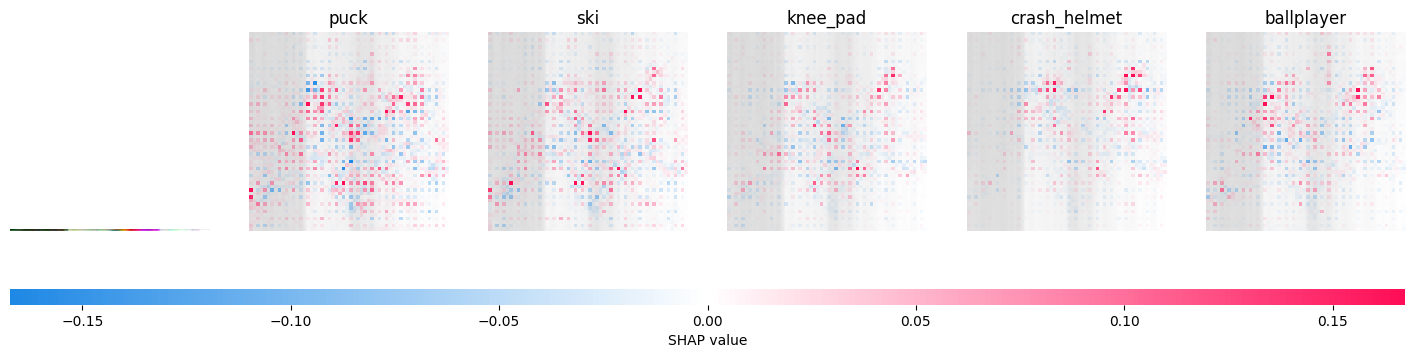

Input Image 1 - SHAP values for 4th Layer


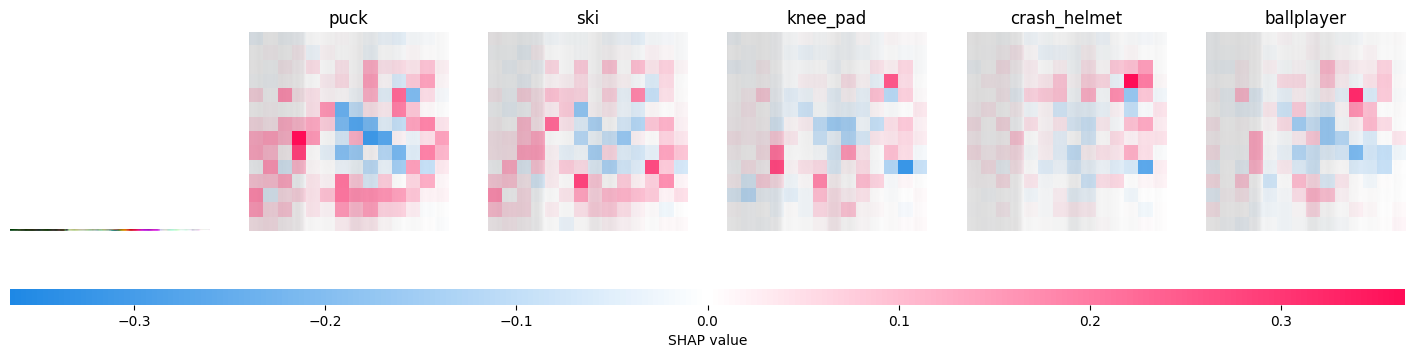

Input Image 2 - SHAP values for 2nd Layer


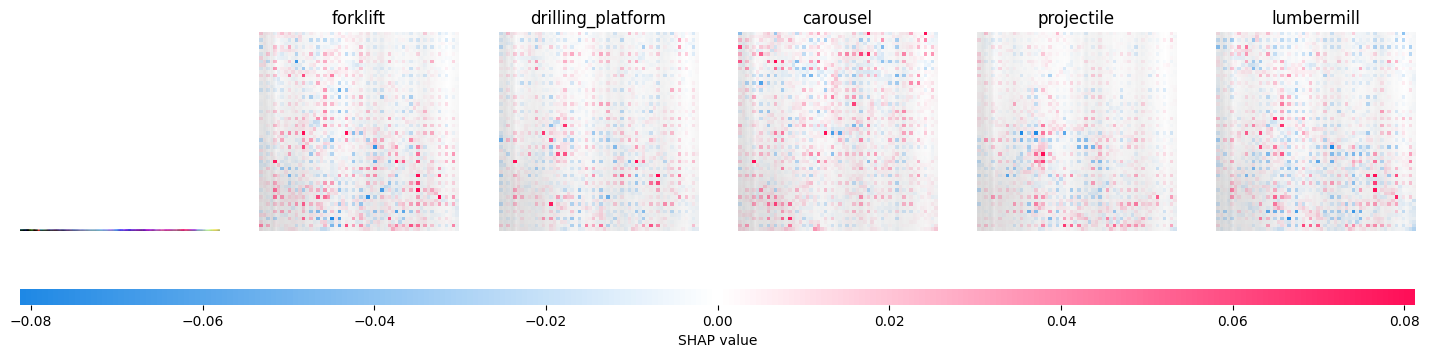

Input Image 2 - SHAP values for 4th Layer


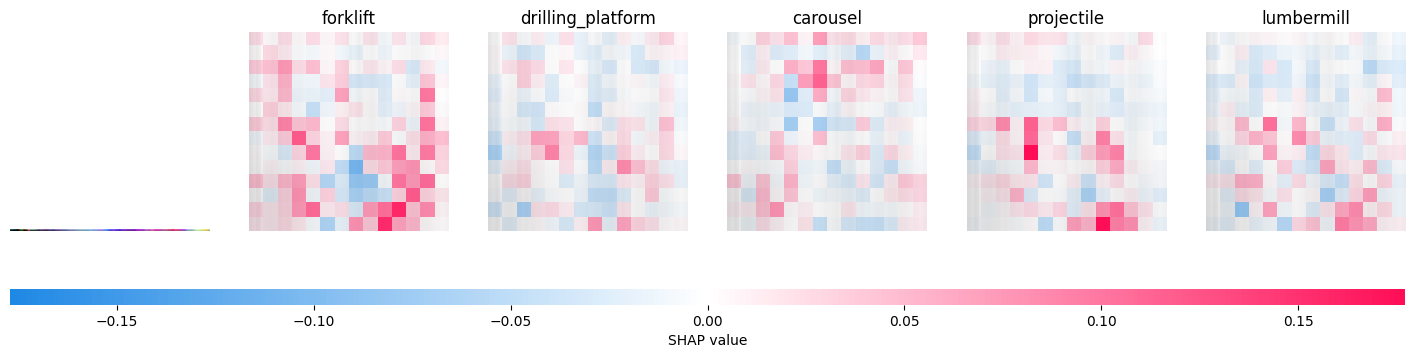

Input Image 3 - SHAP values for 2nd Layer


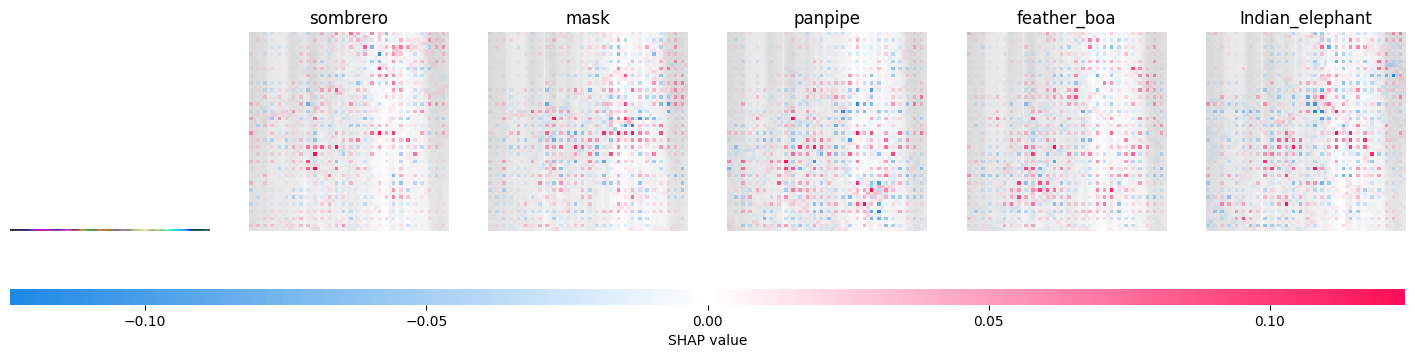

Input Image 3 - SHAP values for 4th Layer


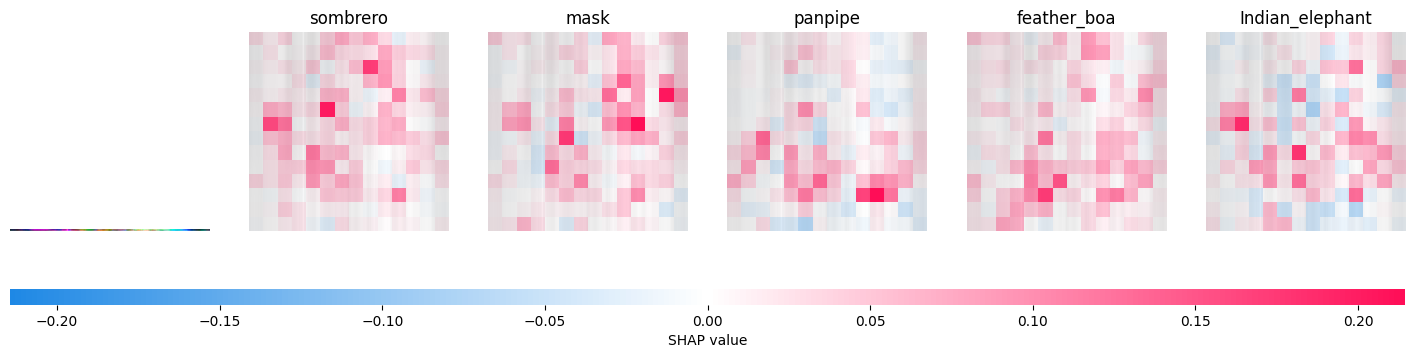

Input Image 4 - SHAP values for 2nd Layer


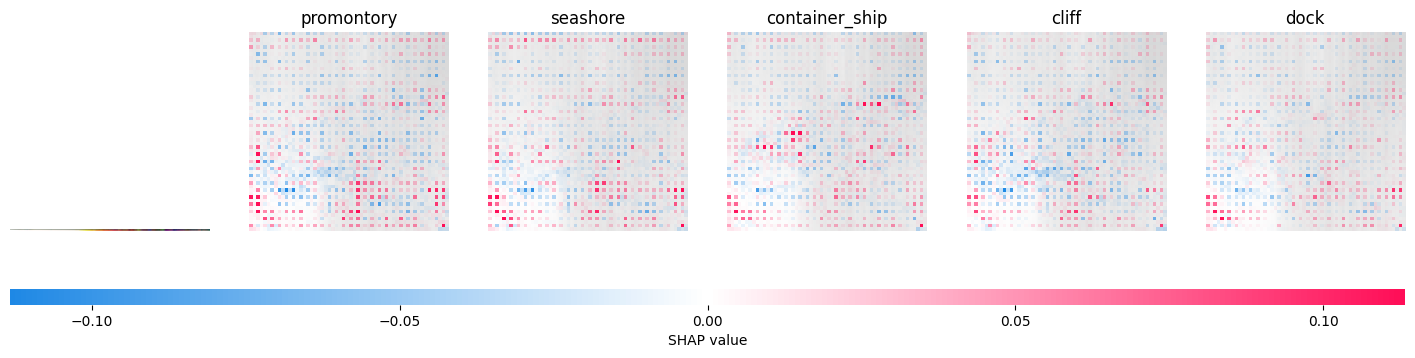

Input Image 4 - SHAP values for 4th Layer


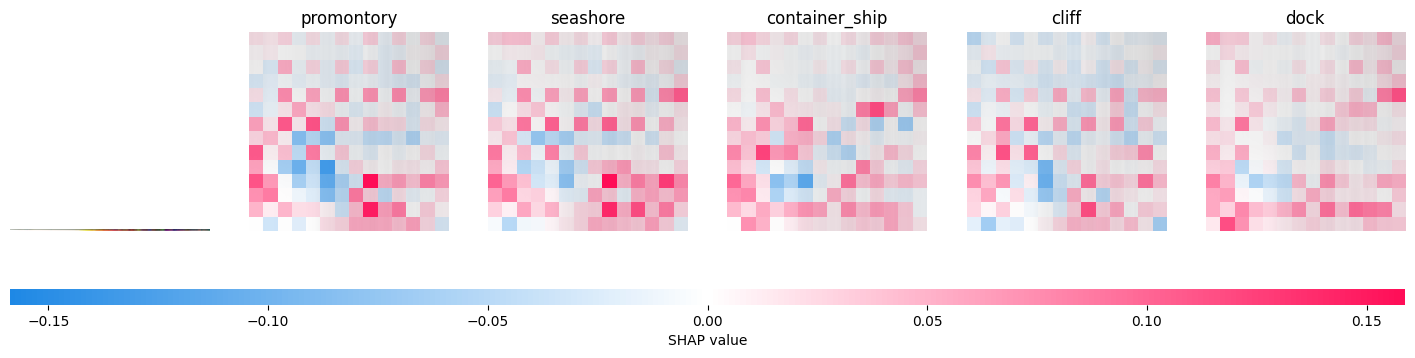

Input Image 5 - SHAP values for 2nd Layer


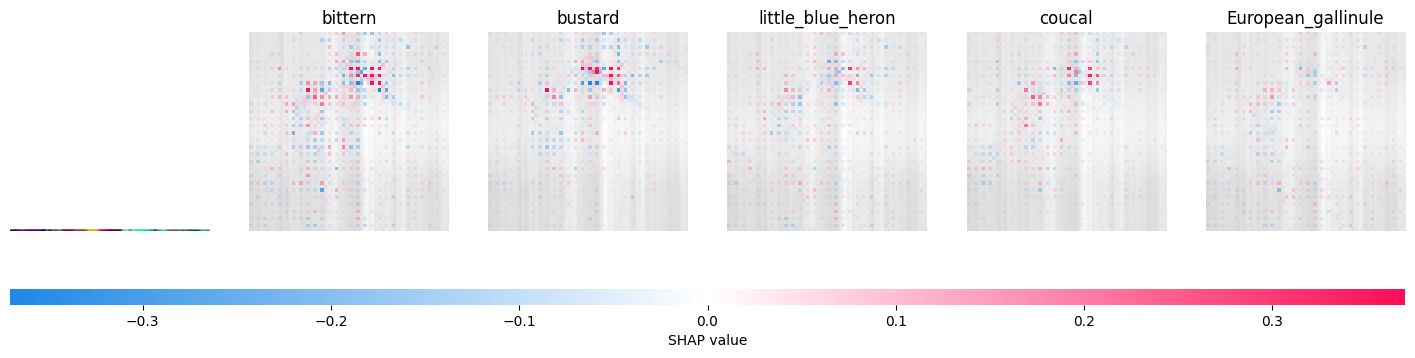

Input Image 5 - SHAP values for 4th Layer


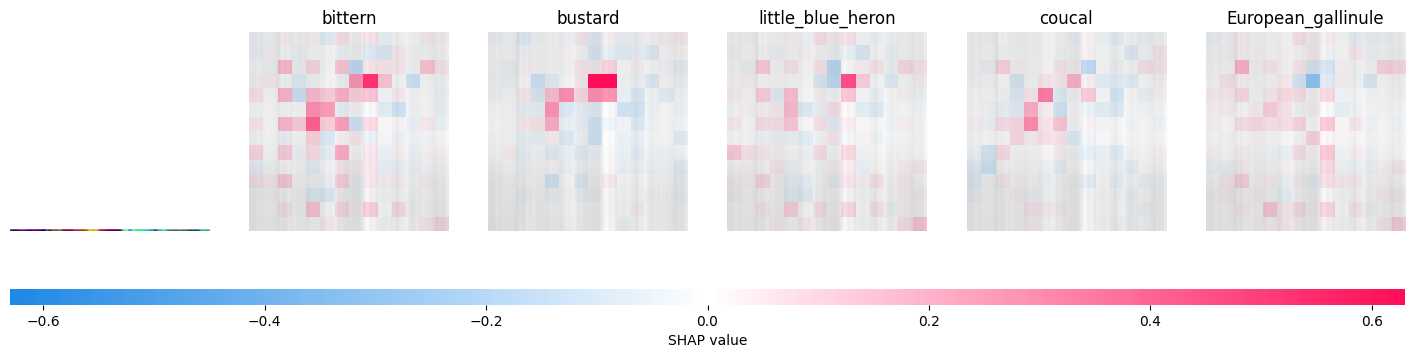

Input Image 6 - SHAP values for 2nd Layer


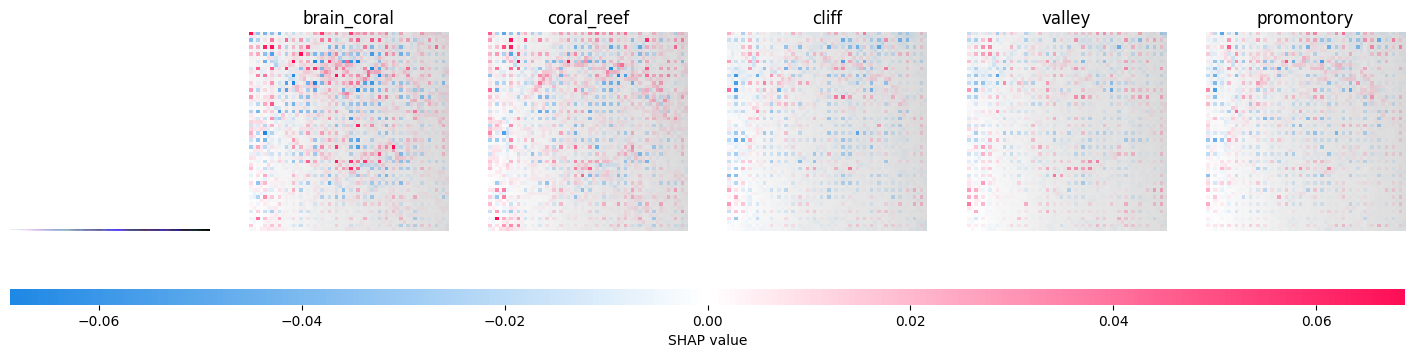

Input Image 6 - SHAP values for 4th Layer


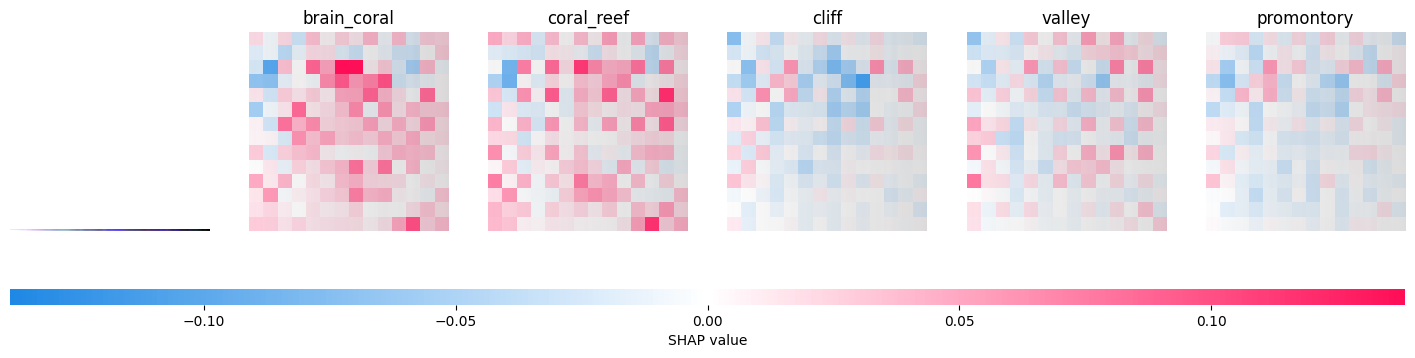

Input Image 7 - SHAP values for 2nd Layer


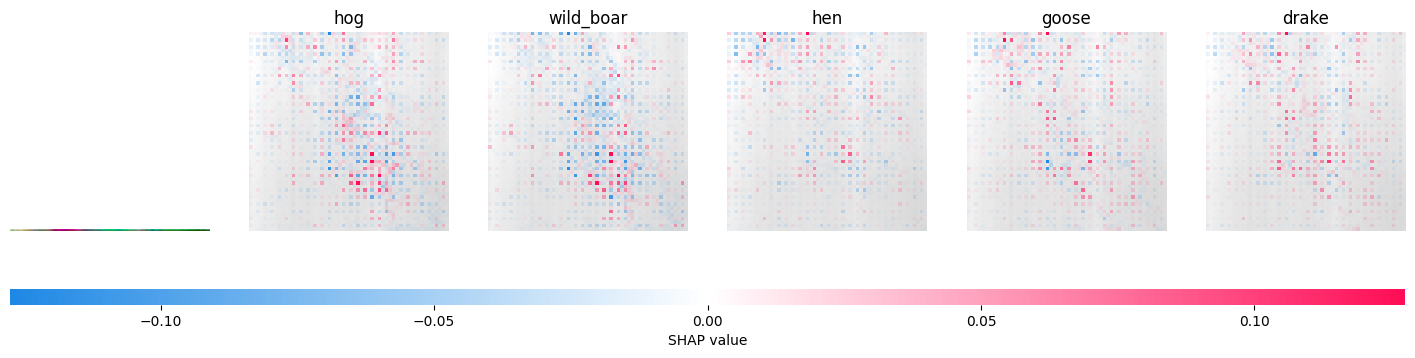

Input Image 7 - SHAP values for 4th Layer


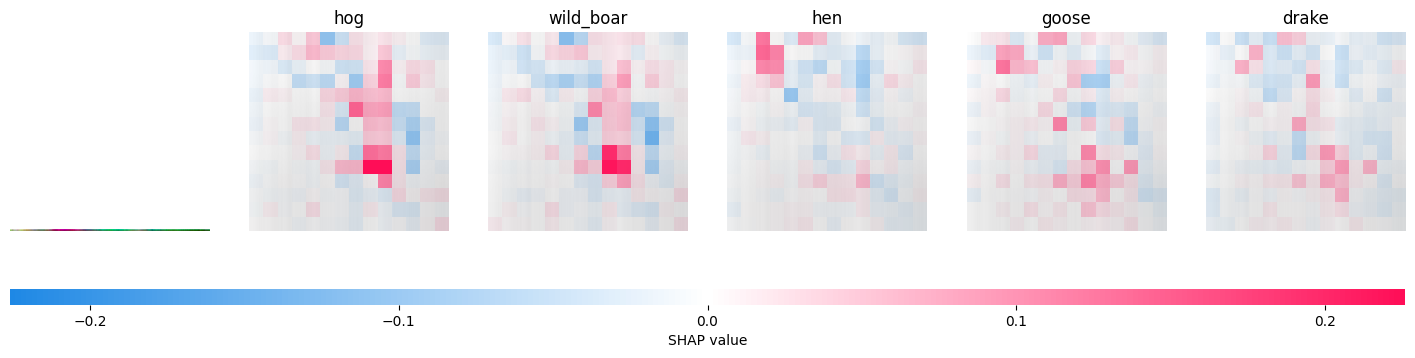

Input Image 8 - SHAP values for 2nd Layer


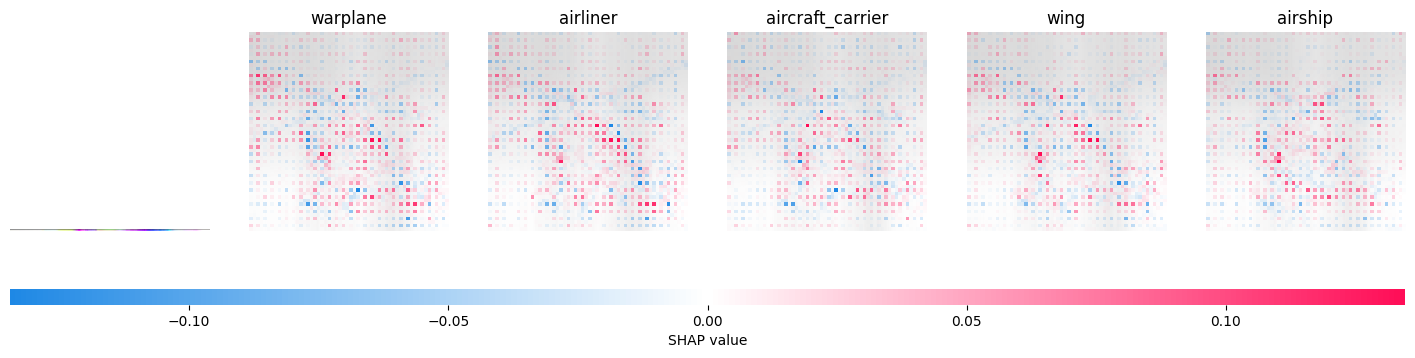

Input Image 8 - SHAP values for 4th Layer


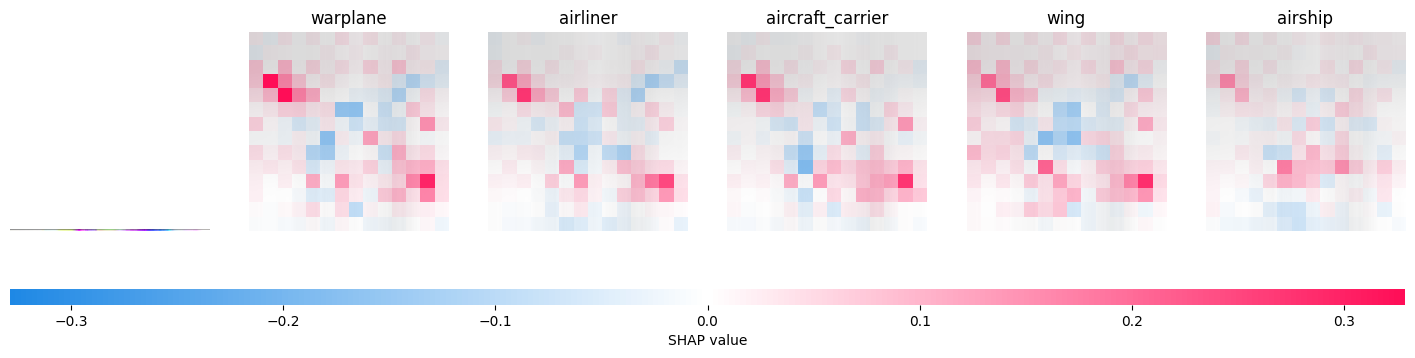

Input Image 9 - SHAP values for 2nd Layer


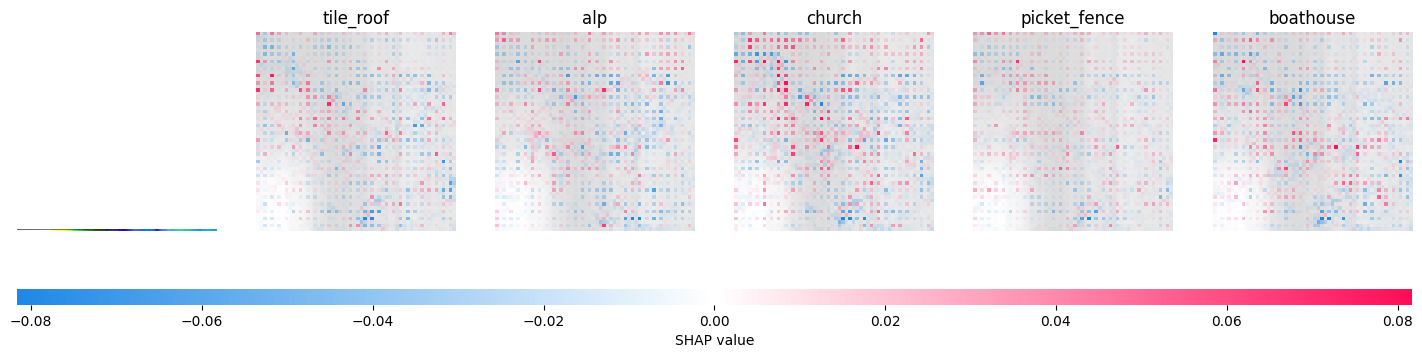

Input Image 9 - SHAP values for 4th Layer


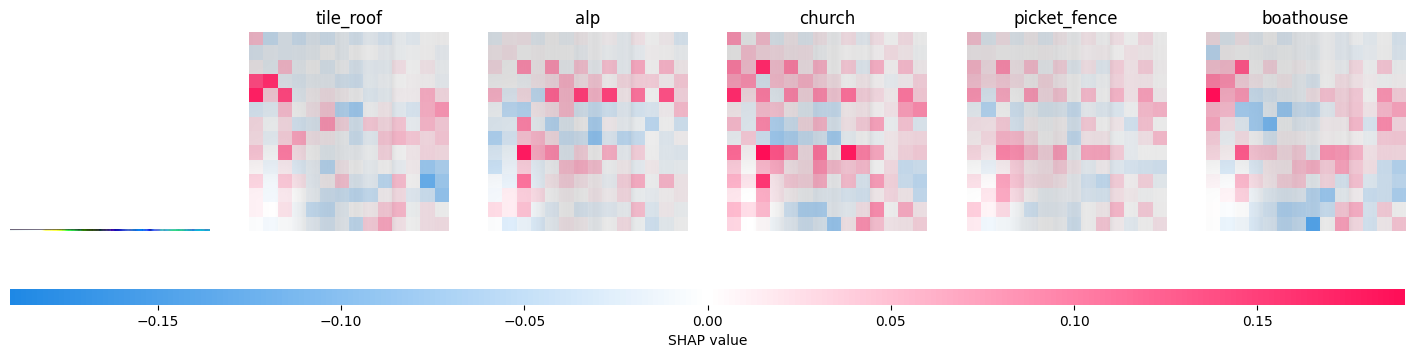

Input Image 10 - SHAP values for 2nd Layer


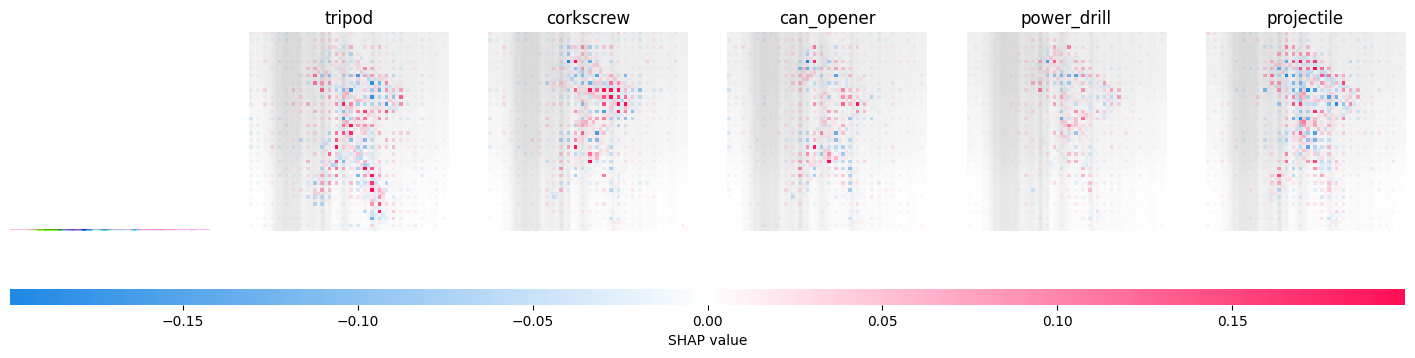

Input Image 10 - SHAP values for 4th Layer


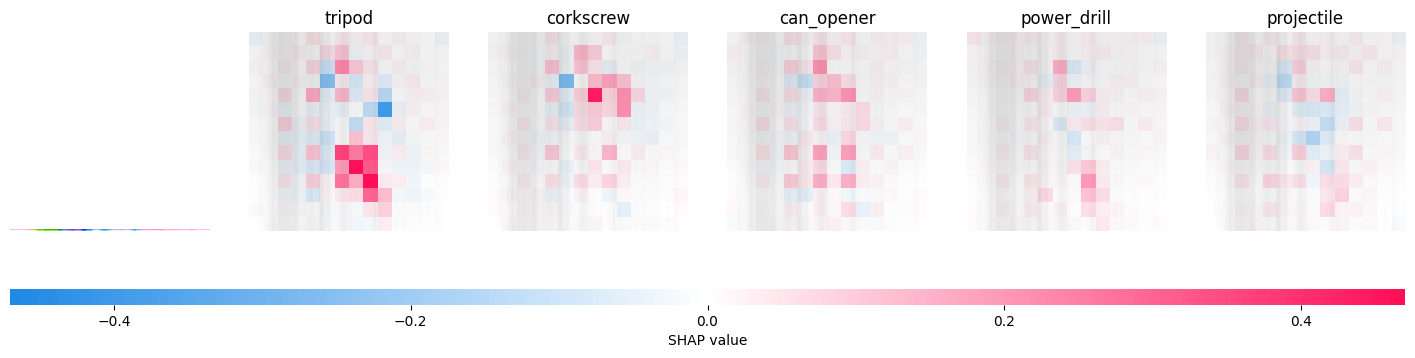

In [ ]:
num_images = normalized_to_explain.shape[0]

for i in range(num_images):
    print(f"Input Image {i + 1} - SHAP values for 2nd Layer")
    shap.image_plot([shap_values_2nd_smoothed[j][i:i+1] for j in range(len(shap_values_2nd_smoothed))],
                    normalized_to_explain.cpu().numpy()[i:i+1], index_names_2nd_smoothed[i:i+1])

    print(f"Input Image {i + 1} - SHAP values for 4th Layer")
    shap.image_plot([shap_values_4th_smoothed[j][i:i+1] for j in range(len(shap_values_4th_smoothed))],
                    normalized_to_explain.cpu().numpy()[i:i+1], index_names_4th_smoothed[i:i+1])
    plt.show()


## References

* SHAP explainer based on superpixels - [notebook](https://slundberg.github.io/shap/notebooks/ImageNet%20VGG16%20Model%20with%20Keras.html)
* SHAP reference notebook - [view on github](https://github.com/slundberg/shap/tree/master/notebooks)
* More various explainers in [ELI5](https://github.com/TeamHG-Memex/eli5)
* Same notebook on Google [Colab](https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb)